# I. Exploratory data analysis and cleaning

We work with a UCI dataset containing laboratory values of blood donors and Hepatitis C patients, aiming to build classification models that differentiate between different liver conditions. The dataset is available below. 

In [ ]:
# For this project we will be using the following libraries:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import recall_score
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

In [ ]:
# Our dataset is available online at UCI machine learning repository 
# https://archive.ics.uci.edu/ml/datasets/HCV+data

url='https://archive.ics.uci.edu/ml/machine-learning-databases/00571/hcvdat0.csv'
df=pd.read_csv(url)

#from google.colab import files
#uploaded = files.upload()
#import io
# df = pd.read_csv(io.BytesIO(uploaded['hcvdat0.csv']))
df['Category'].value_counts()

0=Blood Donor             533
3=Cirrhosis                30
1=Hepatitis                24
2=Fibrosis                 21
0s=suspect Blood Donor      7
Name: Category, dtype: int64

In [ ]:
df.describe()


,Unnamed: 0,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
count,615.000000,615.000000,614.000000,597.000000,614.000000,615.000000,615.000000,615.000000,605.000000,615.000000,615.000000,614.000000
mean,308.000000,47.408130,41.620195,68.283920,28.450814,34.786341,11.396748,8.196634,5.368099,81.287805,39.533171,72.044137
std,177.679487,10.055105,5.780629,26.028315,25.469689,33.090690,19.673150,2.205657,1.132728,49.756166,54.661071,5.402636
min,1.000000,19.000000,14.900000,11.300000,0.900000,10.600000,0.800000,1.420000,1.430000,8.000000,4.500000,44.800000
25%,154.500000,39.000000,38.800000,52.500000,16.400000,21.600000,5.300000,6.935000,4.610000,67.000000,15.700000,69.300000
50%,308.000000,47.000000,41.950000,66.200000,23.000000,25.900000,7.300000,8.260000,5.300000,77.000000,23.300000,72.200000
75%,461.500000,54.000000,45.200000,80.100000,33.075000,32.900000,11.200000,9.590000,6.060000,88.000000,40.200000,75.400000
max,615.000000,77.000000,82.200000,416.600000,325.300000,324.000000,254.000000,16.410000,9.670000,1079.100000,650.900000,90.000000


In [ ]:
# Checking extreeme min and max values in a dataframe we can see that most of them
# indicate progressive stages of hepatitis. We will not remove any outliers 
# because doing so will shrink already small minority classes
df.sort_values(by='CHE')

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
595,596,3=Cirrhosis,56,m,27.0,81.1,17.0,319.8,37.0,1.42,3.54,66.9,93.7,65.3
590,591,3=Cirrhosis,46,m,20.0,NaN,62.0,113.0,254.0,1.48,NaN,114.0,138.0,NaN
611,612,3=Cirrhosis,64,f,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3
601,602,3=Cirrhosis,59,m,31.0,86.3,5.4,95.4,117.0,1.57,3.51,60.5,53.6,68.5
612,613,3=Cirrhosis,64,f,29.0,87.3,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,236,0=Blood Donor,53,m,49.2,71.8,42.8,29.4,6.8,15.10,6.24,107.0,48.3,77.8
183,184,0=Blood Donor,48,m,42.6,69.1,17.6,28.3,7.7,15.40,5.07,81.0,29.9,77.8
209,210,0=Blood Donor,51,m,42.6,69.1,17.6,28.3,7.7,15.40,5.07,81.0,29.9,77.8
108,109,0=Blood Donor,42,m,45.3,55.3,31.0,50.0,18.5,15.43,5.88,83.0,15.4,72.4


In [ ]:
# We have 30 NaN values. Since this is not a time-series dataset and it's fairly small, imputing them with
# mean averages will not cause any feature leakage. 
df.isnull().sum()

Unnamed: 0     0
Category       0
Age            0
Sex            0
ALB            1
ALP           18
ALT            1
AST            0
BIL            0
CHE            0
CHOL          10
CREA           0
GGT            0
PROT           1
dtype: int64

In [ ]:
# The dataset comes pretty tidy. We drop a duplicate index column 'Unnamed: 0'	and encode
# categorical data for smooth preprocessing. 
# One class [0s=suspect Blood Donor] in [Categories] representes 7 instances where medics were not
# able to determine if liver is healthy or damaged. So we will not be able to establish if
# classifying these observations reflects physical truth and therefore drop them. 

df.fillna({'PROT':df['PROT'].mean(), 'GGT':df['GGT'].mean(),'CREA':df['CREA'].mean(),'CHOL':df['CHOL'].mean(),
          'CHE':df['CHE'].mean(), 'BIL':df['BIL'].mean(), 'AST':df['AST'].mean(), 'ALT':df['ALT'].mean(),
           'ALP':df['ALP'].mean(),'ALB':df['ALB'].mean()}, inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
df=df.loc[df['Category']!= "0s=suspect Blood Donor"]
df=df.drop(df.index[533:540])
df['Category'] = df['Category'].map({'0=Blood Donor':'0','1=Hepatitis':'2', '2=Fibrosis':'3','3=Cirrhosis':'4'}).astype(float)
df['Sex']=df['Sex'].map({'m':1, 'f':0}).astype(float)



df['Category'].value_counts()

0.0    533
4.0     30
3.0     21
2.0     17
Name: Category, dtype: int64

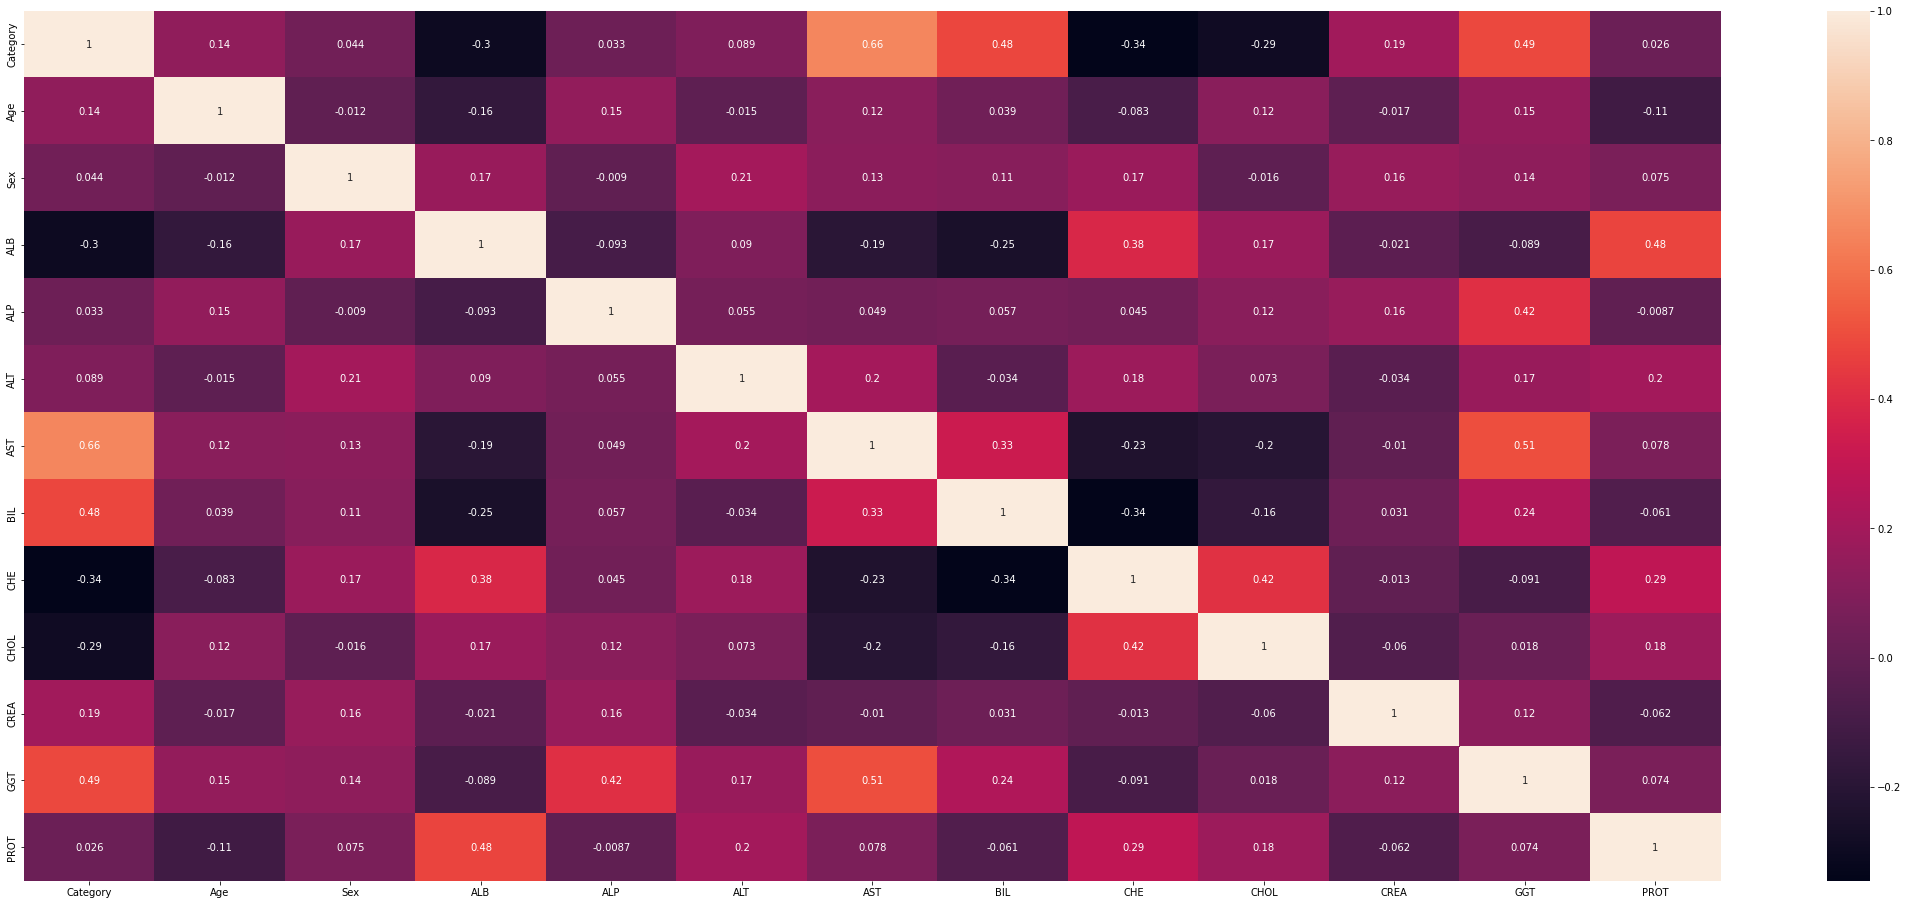

In [ ]:
# We plot a correlation matrix to see if we have any leaky features. There are not feaures with abnormally high 
# corellation coefficients. 
# There are no features like medication status affecting predicted outcomes - very observation represents
# a discrete point in time when a blood sample was taken from an individual 


plt.figure(figsize = (38,16))
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

# II. Oversampling, scaling and splitting the dataset. 



In [ ]:
# To build our models we create a target vector(liver damage category) and a feature matrix
target = 'Category'
y = df[target]
X = df.drop(columns=target)



In [ ]:
# Because our dataset is clearly imbalanced, with majority class representing 89% of observations, we use 
# SMOTE oversampling to create additional synthetic datapoints in minority classes
oversample = SMOTE()
X1, y1 = oversample.fit_resample(X, y)



In [ ]:
df.shape

(601, 13)

In [ ]:
# We split our data into training, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# X_train, y_train - train
# X_val, y_val - TEST
# X_test, y_test - VALIDATION :)


In [ ]:
# For our classification task we establish the baseline accuracy for our model which corresponds to relative class frequency 
# because SMOTE normalized class weights
baseline_acc =y_train.value_counts(normalize=True)
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 4.0    0.253982
0.0    0.251467
3.0    0.247276
2.0    0.247276
Name: Category, dtype: float64


In [ ]:
# We use a scaler to scale our feature matricies 
scaler=MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
X_val_scaled = scaler.fit_transform(X_val)

In [ ]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train_scaled, y_train)

y_pred_dum = dummy_clf.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_pred_dum, digits=3))

print(recall_score(y_test, y_pred_dum,average='weighted'))


              precision    recall  f1-score   support

         0.0      0.000     0.000     0.000       110
         2.0      0.000     0.000     0.000       101
         3.0      0.000     0.000     0.000       107
         4.0      0.255     1.000     0.407       109

    accuracy                          0.255       427
   macro avg      0.064     0.250     0.102       427
weighted avg      0.065     0.255     0.104       427

0.25526932084309134


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# III. Building tree-based models, tuning hyperparameters.

In [ ]:
# First model we try is XGB the one we have highest hopes for. The metrics we use to evaluate our model is recall. 
# In particular the recall for 2,3,4 - the classes indicating liver damage. We are willing to sacrifice precision
# to make sure that the highest number of hepatitus cases are correcly identified.
#  While we can use sklearn.metrics.recall_score to get a weighted average score for recall, in practice we need
# improvement in recall for 2,3 and 4. So we use classification report.

from sklearn.metrics import classification_report, confusion_matrix
modelXGB = XGBClassifier(objective='multi:softprob')
modelXGB.fit(X_train_scaled, y_train)
y_pred_XGB = modelXGB.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_pred_XGB, digits=3))
#f1_score(y_test, y_pred_XGB , average='weighted') 
#metrics.confusion_matrix(y_test, y_pred_XGB)

              precision    recall  f1-score   support

         0.0      1.000     0.945     0.972       110
         2.0      0.833     0.990     0.905       101
         3.0      0.920     0.860     0.889       107
         4.0      0.990     0.936     0.962       109

    accuracy                          0.932       427
   macro avg      0.936     0.933     0.932       427
weighted avg      0.938     0.932     0.933       427



In [ ]:
# After some hyperparameter tuning we arrive to slightly improved recall scores for our class 3
modelXGB = XGBClassifier(max_depth=6, subsample=0.8, objective='multi:softprob')
modelXGB.fit(X_train_scaled, y_train)
y_pred_XGB = modelXGB.predict(X_test_scaled)


print(metrics.classification_report(y_test, y_pred_XGB, digits=3))

              precision    recall  f1-score   support

         0.0      0.955     0.964     0.959       110
         2.0      0.831     0.970     0.895       101
         3.0      0.944     0.794     0.863       107
         4.0      0.963     0.954     0.959       109

    accuracy                          0.920       427
   macro avg      0.923     0.921     0.919       427
weighted avg      0.925     0.920     0.920       427



In [ ]:
# Next classifier we try is random forest
random_forest = RandomForestClassifier(max_depth=6, max_features=3, n_estimators=40, random_state=35) 
random_forest.fit(X_train_scaled, y_train)

y_pred_random_forest= random_forest.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred_random_forest, digits=3))

              precision    recall  f1-score   support

         0.0      1.000     0.927     0.962       110
         2.0      0.870     0.990     0.926       101
         3.0      0.905     0.888     0.896       107
         4.0      0.990     0.954     0.972       109

    accuracy                          0.939       427
   macro avg      0.941     0.940     0.939       427
weighted avg      0.943     0.939     0.940       427



In [ ]:
# We use GridSearchCV for hyperparameter tuning of our models 
params={
         'random_state': [2, 7, 15, 35, 42],
          'max_depth': [1, 2, 3, 4, 5, 6],
          'max_features': [3, 4, 5, 6, 7, 9],
          'n_estimators' :[20, 40, 55, 75, 99]}

random_forest_grid=GridSearchCV(random_forest, param_grid=params, cv=5, n_jobs=-1, verbose=0)
random_forest_grid.fit(X_train_scaled, y_train)
         
print(random_forest_grid.best_estimator_)
print(random_forest_grid.best_params_)

RandomForestClassifier(max_depth=6, max_features=3, n_estimators=99,
                       random_state=15)
{'max_depth': 6, 'max_features': 3, 'n_estimators': 99, 'random_state': 15}


In [ ]:
# Gradient Boosting Classifier showed the best performance with highest recall scores. 
grb_classifier = GradientBoostingClassifier(random_state=0)
grb_model=grb_classifier.fit(X_train_scaled, y_train)

y_pred_grb = grb_model.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_pred_grb, digits=3))

              precision    recall  f1-score   support

         0.0      0.963     0.945     0.954       110
         2.0      0.842     1.000     0.914       101
         3.0      0.948     0.850     0.897       107
         4.0      0.990     0.936     0.962       109

    accuracy                          0.932       427
   macro avg      0.936     0.933     0.932       427
weighted avg      0.937     0.932     0.932       427



In [ ]:
# !!! Gradient Boosting Classifier showed the best performance with highest recall scores. This model is also tuned with
#GridSearchSV. The weighted average recall is 0.979 and more importantly, the recall for damage classes is very robust

grb_classifier = GradientBoostingClassifier(n_estimators=40, learning_rate=0.5, max_features=3, max_depth=6, random_state=0)
grb_model=grb_classifier.fit(X_train_scaled, y_train)

y_pred_grb = grb_model.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_pred_grb, digits=3))

              precision    recall  f1-score   support

         0.0      0.917     1.000     0.957       110
         2.0      0.835     1.000     0.910       101
         3.0      0.963     0.738     0.836       107
         4.0      1.000     0.954     0.977       109

    accuracy                          0.923       427
   macro avg      0.929     0.923     0.920       427
weighted avg      0.930     0.923     0.920       427



In [ ]:
# We re-run the model on our test set and it shows comparable recall weighted average 0.979 
# although with somewhat smaller values for damage classes. 

y_val_grb = grb_model.predict(X_val_scaled)

print(metrics.classification_report(y_val, y_val_grb, digits=3))

              precision    recall  f1-score   support

         0.0      0.932     1.000     0.965       123
         2.0      0.977     0.934     0.955       137
         3.0      0.928     0.985     0.956       131
         4.0      1.000     0.909     0.952       121

    accuracy                          0.957       512
   macro avg      0.959     0.957     0.957       512
weighted avg      0.959     0.957     0.957       512



# IV. Building linear models, tuning hyperparameters.

In [ ]:
# For our regression model we will try multiclass logistic regression classifiers, OVR and multinomial. 

multiclass_LogRegOVR = LogisticRegression(multi_class="ovr")
multiclass_LogRegOVR.fit(X_train_scaled, y_train)

y_pred_LogRegOVR = multiclass_LogRegOVR.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred_LogRegOVR, digits=3))

              precision    recall  f1-score   support

         0.0      0.916     0.891     0.903       110
         2.0      0.714     0.842     0.773       101
         3.0      0.765     0.729     0.746       107
         4.0      0.949     0.862     0.904       109

    accuracy                          0.831       427
   macro avg      0.836     0.831     0.832       427
weighted avg      0.839     0.831     0.833       427



In [ ]:
#After some parameter tuning our recall values have increased by 5%, from 0.822 to 0.871.


multiclass_LogRegOVR = LogisticRegression(solver='liblinear', C=10, class_weight='balanced', multi_class="ovr")
multiclass_LogRegOVR.fit(X_train_scaled, y_train)

y_pred_LogRegOVR = multiclass_LogRegOVR.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred_LogRegOVR, digits=3))

              precision    recall  f1-score   support

         0.0      1.000     0.918     0.957       110
         2.0      0.724     0.911     0.807       101
         3.0      0.757     0.729     0.743       107
         4.0      0.969     0.853     0.907       109

    accuracy                          0.852       427
   macro avg      0.863     0.853     0.854       427
weighted avg      0.866     0.852     0.855       427



In [ ]:
#Multinomial logistic regression

multinomialLogReg = LogisticRegression(class_weight='balanced', multi_class="multinomial")
multinomialLogReg.fit(X_train_scaled, y_train)


y_pred_MultinomialLogReg= multinomialLogReg.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred_MultinomialLogReg, digits=3))
#modelMLTLogReg.score(X_test_scaled, y_test)

              precision    recall  f1-score   support

         0.0      0.889     0.873     0.881       110
         2.0      0.682     0.871     0.765       101
         3.0      0.779     0.692     0.733       107
         4.0      0.947     0.826     0.882       109

    accuracy                          0.815       427
   macro avg      0.824     0.815     0.815       427
weighted avg      0.827     0.815     0.817       427



In [ ]:
# Decision tree classifier 
decision_tree=DecisionTreeClassifier(random_state=0)
decision_tree.fit(X_train_scaled, y_train)

y_pred_decision_tree= decision_tree.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred_decision_tree, digits=3))


              precision    recall  f1-score   support

         0.0      0.856     0.918     0.886       110
         2.0      0.774     0.812     0.792       101
         3.0      0.755     0.664     0.706       107
         4.0      0.936     0.936     0.936       109

    accuracy                          0.834       427
   macro avg      0.830     0.832     0.830       427
weighted avg      0.832     0.834     0.832       427



# V. Conclusions

Starting with the baseline score of 0.247-0.253 we built a number of linear and tree-based models. After tuning hyperparameters, Random Forest Classifier (0.951) and Gradient Boosting Classifier (0.979) showed the highest weighted recall values. The GBC model performance was confirmed by the test score (0.979).
 

0.9484777517564403 RandomForestClassifier
0.9320843091334895 GradientBoostingClassifier
0.9320843091334895 XGBClassifier
0.8313817330210773 DecisionTreeClassifier
0.819672131147541 LogisticRegression


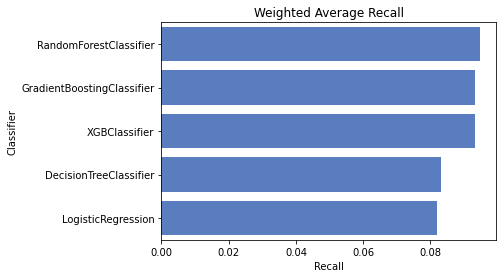

In [ ]:
#The inspiration for the code below was drawn from this project
#https://www.kaggle.com/pavlokoliada/titanikstartedpack

classifiers = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier(objective='multi:softprob'),
    DecisionTreeClassifier(),
    LogisticRegression(solver='liblinear', class_weight='balanced', multi_class="ovr"),
    ]

log_cols2 = ["Classifier", "Recall"]
log2      = pd.DataFrame(columns=log_cols2)



rec_dict2 = {}

classifier_rank = DecisionTreeClassifier()
highest_metric = 0.0


for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train_scaled, y_train)
        train_predictions = clf.predict(X_test_scaled)
        rec = recall_score(y_test, train_predictions,average='weighted')
        if rec > highest_metric:
            print(rec, clf.__class__.__name__)
            best_measure = rec
            best_classifier = clf
        if name in rec_dict2:
            rec_dict2[name] += rec
        else:
            rec_dict2[name] = rec

for clf in rec_dict2:
    rec_dict2[clf] = rec_dict2[clf] / 10.0
    log_entry2 = pd.DataFrame([[clf, rec_dict2[clf]]], columns=log_cols2)
    log2 = log2.append(log_entry2)

plt.xlabel('Recall before tuning')
plt.title('Weighted Average Recall')

sns.set_color_codes("muted")
sns.barplot(x='Recall', y='Classifier', data=log2, color="b")

In [ ]:

classifiers = [
    GradientBoostingClassifier(n_estimators=40, learning_rate=0.5, max_features=3, max_depth=6, random_state=0),
    RandomForestClassifier(max_depth=6, max_features=3, n_estimators=40, random_state=35),
    XGBClassifier(max_depth=6, subsample=0.7, objective='multi:softprob'),
    LogisticRegression(solver='liblinear', C=10, class_weight='balanced', multi_class="ovr"),
    DecisionTreeClassifier()]

log_cols2 = ["Classifier", "Recall"]
log2      = pd.DataFrame(columns=log_cols2)



rec_dict2 = {}

classifier_rank = DecisionTreeClassifier()
highest_metric = 0.0


for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train_scaled, y_train)
        train_predictions = clf.predict(X_test_scaled)
        rec = recall_score(y_test, train_predictions,average='weighted')
        if rec > best_measure:
            print(rec, clf.__class__.__name__)
            best_measure = rec
            best_classifier = clf
        if name in rec_dict2:
            rec_dict2[name] += rec
        else:
            rec_dict2[name] = rec

for clf in rec_dict2:
    rec_dict2[clf] = rec_dict2[clf] / 10.0
    log_entry2 = pd.DataFrame([[clf, rec_dict2[clf]]], columns=log_cols2)
    log2 = log2.append(log_entry2)

plt.xlabel('Recall')
plt.title('Weighted Average Recall After Hyperparameter Tuning')

sns.set_color_codes("muted")
sns.barplot(x='Recall', y='Classifier', data=log2, color="b")